In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from scipy import stats
import plotly.express as px

In [7]:
!pip install lifelines

In [8]:
!pip install ucimlrepo

In [9]:
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter
from lifelines.statistics import logrank_test

# DATA from UCI

In [22]:
from ucimlrepo import fetch_ucirepo
# fetch dataset
support2 = fetch_ucirepo(id=880)

# data (as pandas dataframes)
X = support2.data.features
y = support2.data.targets
data = pd.concat([X,y], axis=1)

# print(support2.metadata)

# variable information
#print(support2.variables)
print(data)

           age     sex            dzgroup             dzclass  num.co   edu  \
0     62.84998    male        Lung Cancer              Cancer       0  11.0   
1     60.33899  female          Cirrhosis  COPD/CHF/Cirrhosis       2  12.0   
2     52.74698  female          Cirrhosis  COPD/CHF/Cirrhosis       2  12.0   
3     42.38498  female        Lung Cancer              Cancer       2  11.0   
4     79.88495  female  ARF/MOSF w/Sepsis            ARF/MOSF       1   NaN   
...        ...     ...                ...                 ...     ...   ...   
9100  66.07300    male  ARF/MOSF w/Sepsis            ARF/MOSF       1   8.0   
9101  55.15399  female               Coma                Coma       1  11.0   
9102  70.38196    male  ARF/MOSF w/Sepsis            ARF/MOSF       1   NaN   
9103  47.01999    male       MOSF w/Malig            ARF/MOSF       1  13.0   
9104  81.53894  female  ARF/MOSF w/Sepsis            ARF/MOSF       1   8.0   

          income  scoma  charges      totcst  ...  

In [23]:
data['death']

0       0
1       1
2       1
3       1
4       0
       ..
9100    0
9101    0
9102    0
9103    1
9104    1
Name: death, Length: 9105, dtype: int64

In [24]:
print(support2.variables)

        name     role         type      demographic  \
0         id       ID      Integer             None   
1        age  Feature   Continuous              Age   
2      death   Target   Continuous             None   
3        sex  Feature  Categorical              Sex   
4   hospdead   Target       Binary             None   
5       slos    Other   Continuous             None   
6     d.time    Other   Continuous             None   
7    dzgroup  Feature  Categorical             None   
8    dzclass  Feature  Categorical             None   
9     num.co  Feature   Continuous             None   
10       edu  Feature  Categorical  Education Level   
11    income  Feature  Categorical           Income   
12     scoma  Feature   Continuous             None   
13   charges  Feature   Continuous             None   
14    totcst  Feature   Continuous             None   
15   totmcst  Feature   Continuous             None   
16   avtisst  Feature   Continuous             None   
17      ra

In [25]:
#checking data types
print(data.dtypes)
print("*"*50)

#checking null values in data
print("Null values")
print(data.isnull().sum())


age         float64
sex          object
dzgroup      object
dzclass      object
num.co        int64
edu         float64
income       object
scoma       float64
charges     float64
totcst      float64
totmcst     float64
avtisst     float64
race         object
sps         float64
aps         float64
surv2m      float64
surv6m      float64
hday          int64
diabetes      int64
dementia      int64
ca           object
prg2m       float64
prg6m       float64
dnr          object
dnrday      float64
meanbp      float64
wblc        float64
hrt         float64
resp        float64
temp        float64
pafi        float64
alb         float64
bili        float64
crea        float64
sod         float64
ph          float64
glucose     float64
bun         float64
urine       float64
adlp        float64
adls        float64
adlsc       float64
death         int64
hospdead      int64
sfdm2        object
dtype: object
**************************************************
Null values
age            0
sex   

In [26]:
print("data size before dropping: ", data.shape)
data=data.dropna()
print("data size after dropping: ",data.shape)


data size before dropping:  (9105, 45)
data size after dropping:  (306, 45)


After dropping records having any missing value we are left with 306 patients, a significant decrease in dataset.

In [27]:
data

,age,sex,dzgroup,dzclass,num.co,edu,income,scoma,charges,totcst,...,ph,glucose,bun,urine,adlp,adls,adlsc,death,hospdead,sfdm2
834,55.98599,male,CHF,COPD/CHF/Cirrhosis,3,18.0,>$50k,0.0,90756.0,45550.0625,...,7.500000,141.0,31.0,1875.0,0.0,0.0,0.0,1,1,<2 mo. follow-up
903,35.26599,male,ARF/MOSF w/Sepsis,ARF/MOSF,0,12.0,$11-$25k,0.0,48956.0,23854.9062,...,7.319336,110.0,4.0,2870.0,6.0,6.0,6.0,0,0,SIP>=30
907,76.44098,male,ARF/MOSF w/Sepsis,ARF/MOSF,2,12.0,$25-$50k,0.0,23486.0,11454.5703,...,7.409180,189.0,69.0,2560.0,0.0,0.0,0.0,1,0,no(M2 and SIP pres)
972,48.47098,female,Lung Cancer,Cancer,1,17.0,under $11k,0.0,41422.0,21064.2656,...,7.469727,184.0,9.0,2800.0,1.0,0.0,0.0,1,0,<2 mo. follow-up
1171,41.42599,male,ARF/MOSF w/Sepsis,ARF/MOSF,3,12.0,$25-$50k,41.0,275961.0,39765.2500,...,7.479492,128.0,19.0,4210.0,2.0,2.0,2.0,0,0,no(M2 and SIP pres)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9016,68.41095,male,Coma,Coma,1,14.0,$25-$50k,26.0,50312.0,33776.4688,...,7.439453,141.0,12.0,2500.0,0.0,0.0,0.0,1,0,<2 mo. follow-up
9055,74.05896,female,Lung Cancer,Cancer,1,11.0,$11-$25k,0.0,13262.0,8684.1641,...,7.429688,76.0,39.0,2625.0,5.0,7.0,7.0,1,0,adl>=4 (>=5 if sur)
9066,69.36597,male,ARF/MOSF w/Sepsis,ARF/MOSF,0,12.0,$25-$50k,0.0,6555.0,4531.9766,...,7.449219,149.0,30.0,4375.0,0.0,0.0,0.0,0,0,no(M2 and SIP pres)
9081,54.05298,male,Lung Cancer,Cancer,1,12.0,$25-$50k,0.0,7228.0,4629.1406,...,7.479492,121.0,47.0,3100.0,0.0,0.0,0.0,1,0,no(M2 and SIP pres)


We will consider `age` and `death` column only for KM and NA methods, as they only consider time and event.

In [31]:
#looking for inappropriate values and number of values
print(data['age'].value_counts())
print(data[data['age']==None])
print(data['death'].value_counts())

79.67694    2
57.88098    2
55.98599    1
59.00299    1
30.93500    1
           ..
69.92499    1
71.43896    1
62.73499    1
62.20898    1
79.17596    1
Name: age, Length: 304, dtype: int64
Empty DataFrame
Columns: [age, sex, dzgroup, dzclass, num.co, edu, income, scoma, charges, totcst, totmcst, avtisst, race, sps, aps, surv2m, surv6m, hday, diabetes, dementia, ca, prg2m, prg6m, dnr, dnrday, meanbp, wblc, hrt, resp, temp, pafi, alb, bili, crea, sod, ph, glucose, bun, urine, adlp, adls, adlsc, death, hospdead, sfdm2]
Index: []

[0 rows x 45 columns]
1    168
0    138
Name: death, dtype: int64


All values are appropriate and `death` column have 168 patients have been died while 138 are alive hence data is balanced.

In [32]:
#changing object to int data type
data = data.astype({'age':float,'death':int})
print(data.dtypes)

age         float64
sex          object
dzgroup      object
dzclass      object
num.co        int64
edu         float64
income       object
scoma       float64
charges     float64
totcst      float64
totmcst     float64
avtisst     float64
race         object
sps         float64
aps         float64
surv2m      float64
surv6m      float64
hday          int64
diabetes      int64
dementia      int64
ca           object
prg2m       float64
prg6m       float64
dnr          object
dnrday      float64
meanbp      float64
wblc        float64
hrt         float64
resp        float64
temp        float64
pafi        float64
alb         float64
bili        float64
crea        float64
sod         float64
ph          float64
glucose     float64
bun         float64
urine       float64
adlp        float64
adls        float64
adlsc       float64
death         int64
hospdead      int64
sfdm2        object
dtype: object


In [34]:
data['age'].describe()

count    306.000000
mean      63.167131
std       15.302710
min       18.775990
25%       53.617240
50%       64.761475
75%       74.199970
max       99.198000
Name: age, dtype: float64

# Kaplan-Meier Method

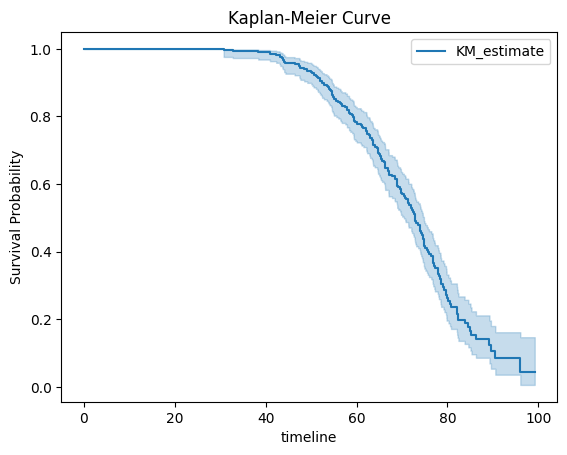

In [37]:
#Plotting Kaplan Meier curve
T = data['age']
E = data['death']

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)
plt.ylabel("Survival Probability")
plt.xlabel("time")
plt.title("Kaplan-Meier Curve")
kmf.plot()
plt.show()

In [38]:
kmf.median_survival_time_

72.86798

Median age is 72.86, which showing that 50% people will survie atleast till the age of 72.86 years

In [39]:
kmf.confidence_interval_survival_function_

,KM_estimate_lower_0.95,KM_estimate_upper_0.95
0.00000,1.000000,1.000000
18.77599,1.000000,1.000000
18.84999,1.000000,1.000000
19.34299,1.000000,1.000000
21.13100,1.000000,1.000000
...,...,...
90.52399,0.035779,0.161571
92.68195,0.035779,0.161571
95.40295,0.035779,0.161571
96.02496,0.005545,0.146809


import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_0, *['KM_estimate_lower_0.95'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_1, *['KM_estimate_upper_0.95'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plot(df, x_colname, y_colname, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(6 * figscale, 6 * figscale))
  df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha)
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plot(_df_2, *['KM_estimate_lower_0.95', 'KM_estimate_upper_0.95'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_3, *['KM_estimate_lower_0.95'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_4, *['KM_estimate_upper_0.95'], **{})
chart

Lifeline package uses Greenwood's exponential formula to calculate confidence interval

# Nelson Aalen Method

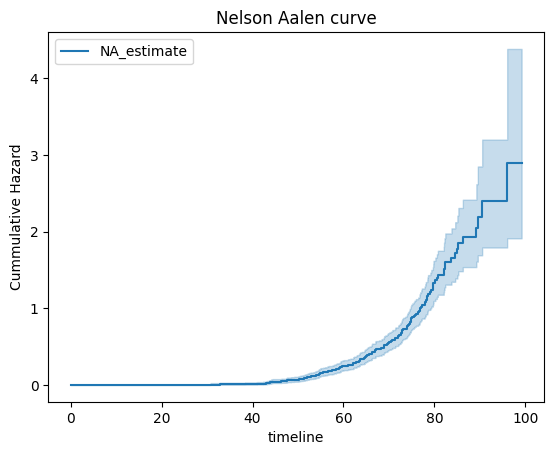

In [41]:
NA_model = NelsonAalenFitter()
NA_model.fit(T, event_observed=E)
plt.ylabel("Cummulative Hazard")
plt.title("Nelson Aalen curve")
NA_model.plot()
plt.legend(loc='upper left')
plt.show()

cummulative hazard is increasing with the age

In [42]:
NA_model.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.00000,0,0,0,306,306
18.77599,1,0,1,0,306
18.84999,1,0,1,0,305
19.34299,1,0,1,0,304
21.13100,1,0,1,0,303
...,...,...,...,...,...
90.52399,1,1,0,0,5
92.68195,1,0,1,0,4
95.40295,1,0,1,0,3


# Log-Rank Test

In [43]:
mask_female = f'sex == "female"'
mask_male = f'sex == "male"'
print(mask_male)

durations_A=data.query(mask_female)['age']
durations_B=data.query(mask_male)['age']
event_observed_A=data.query(mask_female)['death']
event_observed_B=data.query(mask_male)['death']

sex == "male"


In [44]:
plt.figure(figsize=(20, 10))

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

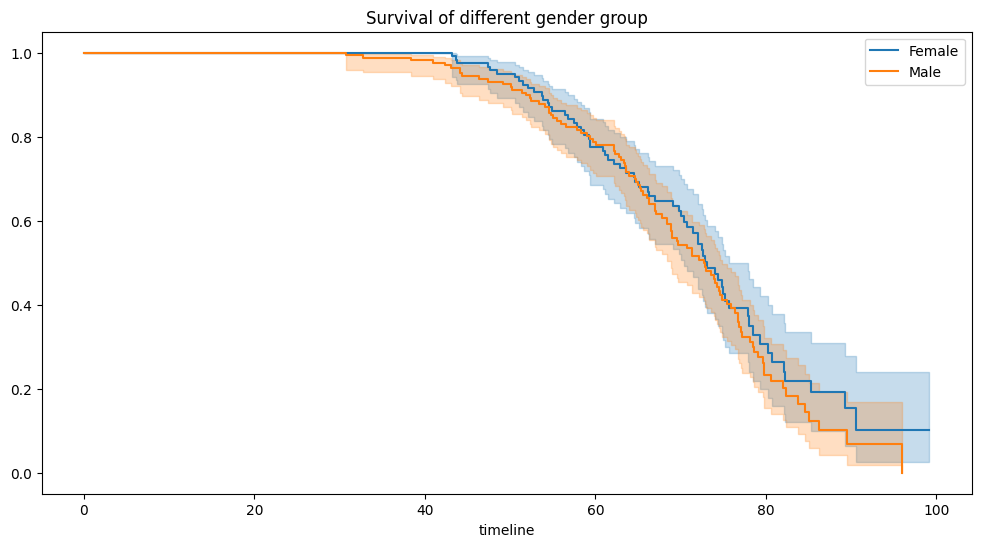

In [45]:
plt.figure(figsize=(12, 6))
kmf = KaplanMeierFitter()
kmf.fit(durations = durations_A, event_observed = event_observed_A, label = "Female")
kmf.plot_survival_function()
kmf.fit(durations_B, event_observed = event_observed_B, label = "Male")
kmf.plot_survival_function()
plt.title("Survival of different gender group")
plt.show()

From above graph there is no clear difference in survival curve for all time between male and female, but after age of 60 female have higher chances of survival. Hence we will perform log rank statistical test to check Null Hypothesis that hazard ratio of both group are same.

In [52]:
logrank_test_result = logrank_test(durations_A,durations_B,
    event_observed_A,event_observed_B )

logrank_test_result.print_summary()



<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.87 0.35      1.51

Since p-value is >0.05 hence we will accept null hypothesis that both males and females have same hazard ration in time. The logrank test has maximum power when the assumption of proportional hazards is true. As a consequence, if the survival curves cross, the logrank test will give an inaccurate assessment of differences.

## Cox-PH Model

The Schoenfeld residuals are calculated as the difference between the observed and expected log hazard ratios.

The plot of the scaled Schoenfeld residuals versus time is used to assess the proportional hazards assumption. If the residuals are randomly scattered around zero, it indicates that the proportional hazards assumption is met. However, if the residuals show a pattern of increasing or decreasing over time, it indicates that the proportional hazards assumption is not met.

The lifeline package also provides another method called "proportional_hazard_test" which is based on the Cox-Snell residuals and it is used to test the proportionality of hazards assumption.




   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 306 total observations, 138 right-censored observations>
         test_name = proportional_hazard_test

---
              test_statistic    p  -log2(p)
crea    km              0.41 0.52      0.93
        rank            0.41 0.52      0.93
glucose km              6.18 0.01      6.27
        rank            6.21 0.01      6.30
hrt     km              0.66 0.42      1.26
        rank            0.72 0.40      1.33



1. Variable 'glucose' failed the non-proportional test: p-value is 0.0127.

   Advice 1: the functional form of the variable 'glucose' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'glucose' using pd.cut, and then specify it in
`strata=['glucose', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Intr

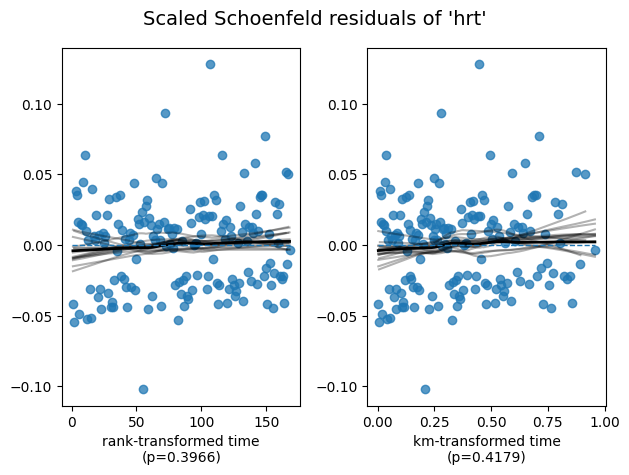

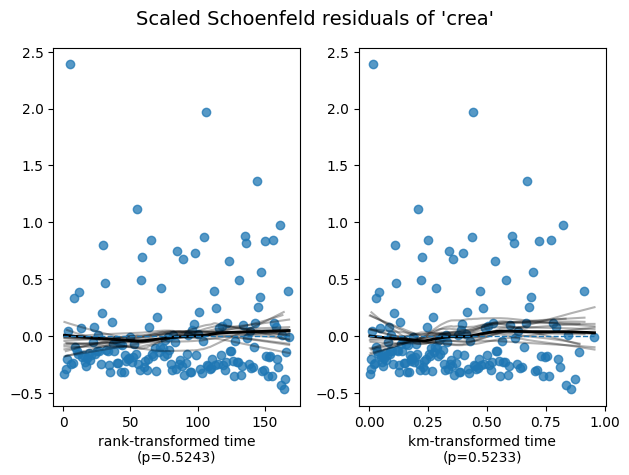

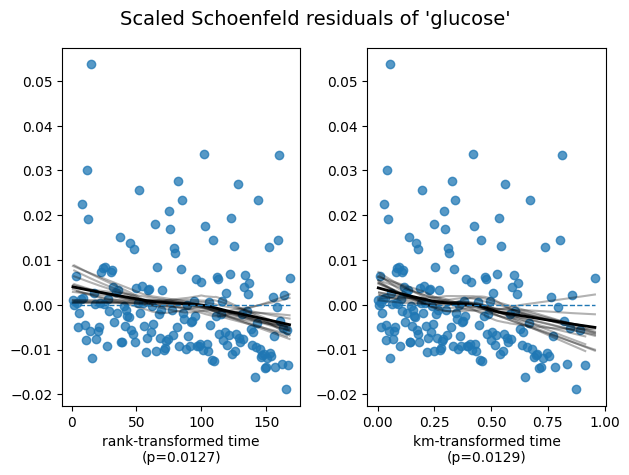

In [72]:
cph = CoxPHFitter()
cph.fit(df=data, duration_col='age', event_col='death',formula='hrt+crea+glucose')
assumptions = cph.check_assumptions(data, show_plots=True)
print(assumptions)

`glucose` failed proportionality hazard test hence removing it


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.
[[<Axes: xlabel='rank-transformed time\n(p=0.5026)'>, <Axes: xlabel='km-transformed time\n(p=0.5168)'>], [<Axes: xlabel='rank-transformed time\n(p=0.2679)'>, <Axes: xlabel='km-transformed time\n(p=0.3368)'>], [<Axes: xlabel='rank-transformed time\n(p=0.4933)'>, <Axes: xlabel='km-transformed time\n(p=0.4780)'>], [<Axes: xlabel='rank-transformed time\n(p=0.2605)'>, <Axes: xlabel='km-transformed time\n(p=0.2443)'>], [<Axes: xlabel='rank-transformed time\n(p=0.4296)'>, <Axes: xlabel='km-transformed time\n(p=0.5410)'>], [<Axes: xlabel='rank-transformed time\n(p=0.8640)'>, <Axes

<lifelines.CoxPHFitter: fitted with 306 total observations, 138 right-censored observations>
             duration col = 'age'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 306
number of events observed = 168
   partial log-likelihood = -785.34
         time fit was run = 2023-10-20 16:54:33 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
hrt         0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
crea       -0.06       0.94       0.05            -0.16             0.05                 0.85                 1.05
aps        -0.01       0.99       0.01            -0.03             0.00                 0.98                 1.00
sps         0.04       1.05       0.02             0.01             0.08                 1.02                 1.08
bun        -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
urine      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
diabetes    0.12       1.12       0.20            -0.29             0.52                 0.75                 1.68

            cmp to     z      p   -log2(p)
covariate                                 
hrt           0.00  0.38   0.71       0.50
crea          0.00 -1.08   0.28       1.83
aps           0.00 -1.40   0.16       2.63
sps           0.00  2.93 <0.005       8.22
bun           0.00 -0.32   0.75       0.42
urine         0.00 -0.57   0.57       0.82
diabetes      0.00  0.56   0.57       0.80
---
Concordance = 0.55
Partial AIC = 1584.67
log-likelihood ratio test = 11.93 on 7 df
-log2(p) of ll-ratio test = 3.28

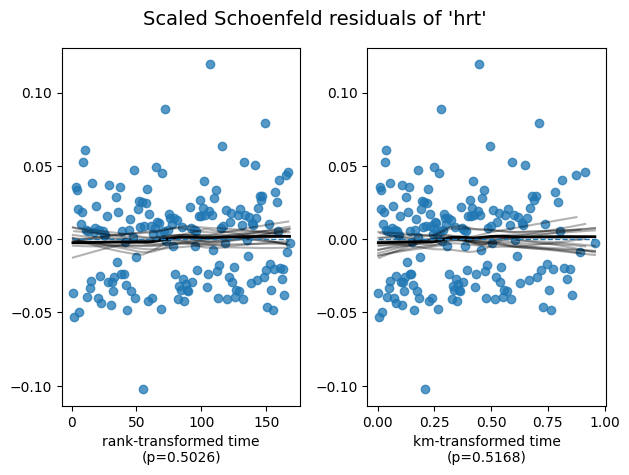

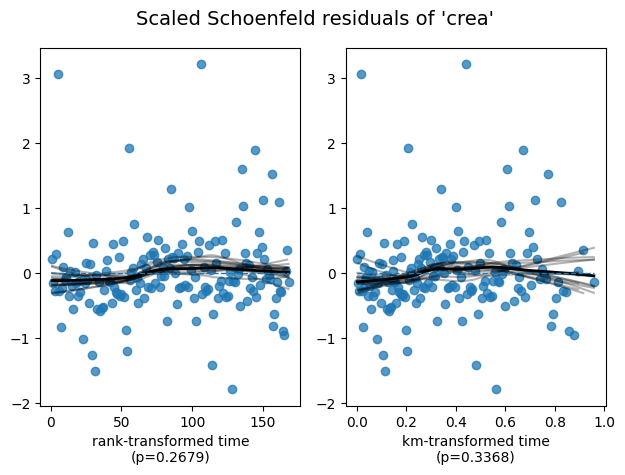

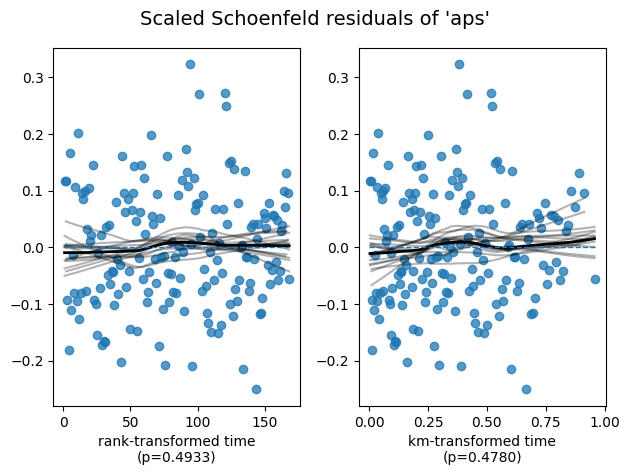

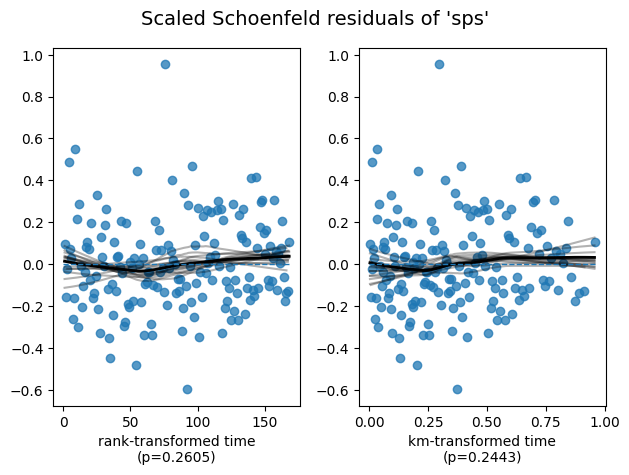

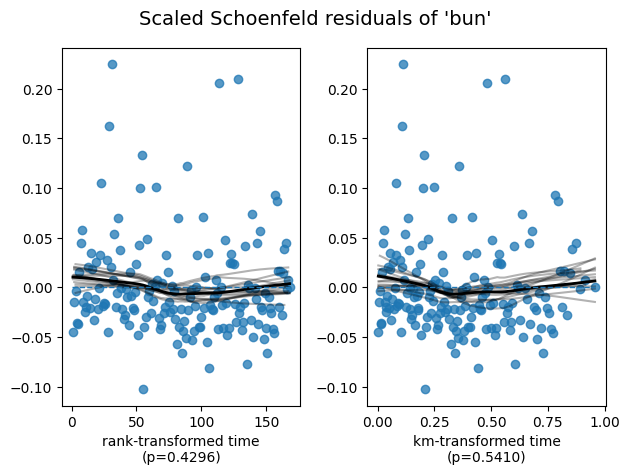

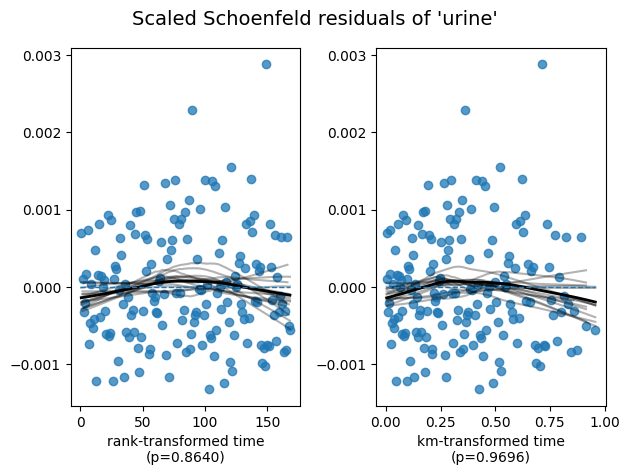

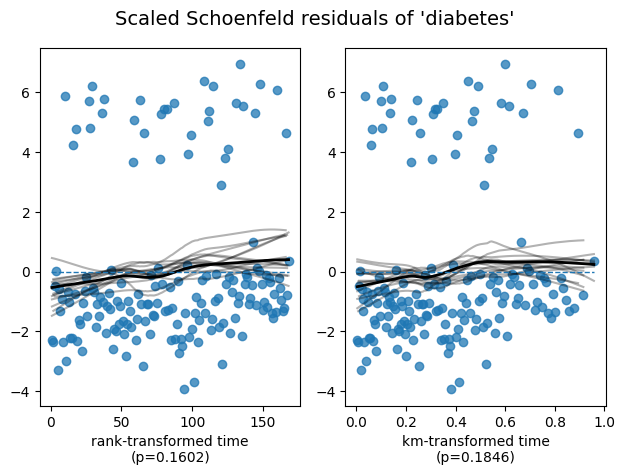

In [86]:
cph = CoxPHFitter()
cph.fit(df=data, duration_col='age', event_col='death',formula='hrt+crea+aps+sps+bun+urine+diabetes')
assumptions = cph.check_assumptions(data, show_plots=True)
print(assumptions)
cph.print_summary()

In [75]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 306 total observations, 138 right-censored observations>
             duration col = 'age'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 306
number of events observed = 168
   partial log-likelihood = -785.34
         time fit was run = 2023-10-20 16:48:42 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
hrt         0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
crea       -0.06       0.94       0.05            -0.16             0.05                 0.85                 1.05
aps        -0.01       0.99       0.01            -0.03             0.00                 0.98                 1.00
sps         0.04       1.05       0.02             0.01             0.08                 1.02                 1.08
diabetes    0.12       1.12       0.20            -0.29             0.52                 0.75                 1.68
bun        -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
urine      -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

            cmp to     z      p   -log2(p)
covariate                                 
hrt           0.00  0.38   0.71       0.50
crea          0.00 -1.08   0.28       1.83
aps           0.00 -1.40   0.16       2.63
sps           0.00  2.93 <0.005       8.22
diabetes      0.00  0.56   0.57       0.80
bun           0.00 -0.32   0.75       0.42
urine         0.00 -0.57   0.57       0.82
---
Concordance = 0.55
Partial AIC = 1584.67
log-likelihood ratio test = 11.93 on 7 df
-log2(p) of ll-ratio test = 3.28

the "z" statistic refers to the Wald statistic for testing the null hypothesis that the coefficient for a predictor variable is equal to zero. In other words, it tests whether or not the predictor variable has a significant association with the outcome of interest.
It is computed as the coefficient of the predictor variable divided by its standard error. The p-value associated with the "z" statistic is used to determine the significance of the predictor variable.

<Axes: xlabel='log(HR) (95% CI)'>

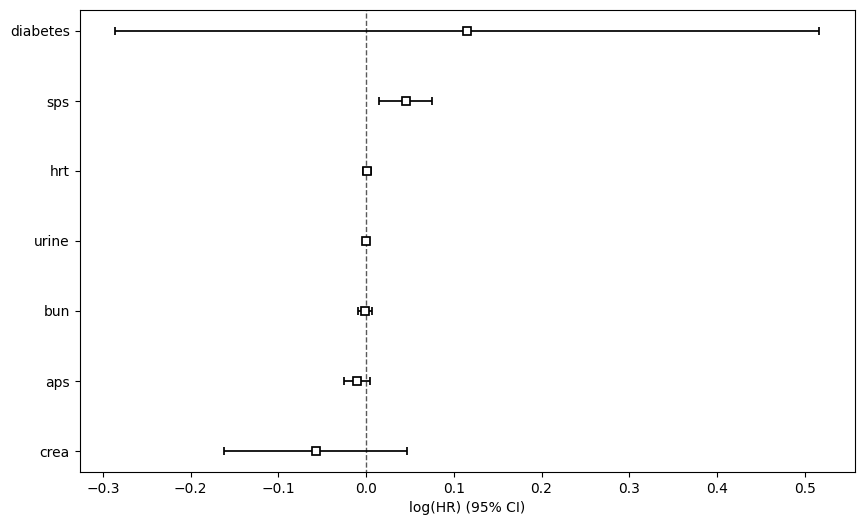

In [76]:
plt.subplots(figsize = (10, 6))
cph.plot()

lower confidence on diabetes

# Brain Cancer

https://github.com/cran/ISLR2/blob/master/data/BrainCancer.rda

In [89]:
!pip install pyreadr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.8/434.8 kB 5.9 MB/s eta 0:00:00


In [100]:
import pyreadr

result = pyreadr.read_r('BrainCancer(R).rda')

In [101]:
result

OrderedDict([('BrainCancer',
                     sex   diagnosis             loc  ki    gtv stereo  status   time
              0   Female  Meningioma  Infratentorial  90   6.11    SRS       0  57.64
              1     Male   HG glioma  Supratentorial  90  19.35    SRT       1   8.98
              2   Female  Meningioma  Infratentorial  70   7.95    SRS       0  26.46
              3   Female   LG glioma  Supratentorial  80   7.61    SRT       1  47.80
              4     Male   HG glioma  Supratentorial  90   5.06    SRT       1   6.30
              ..     ...         ...             ...  ..    ...    ...     ...    ...
              83    Male   HG glioma  Supratentorial  80   0.16    SRT       1  20.69
              84    Male   HG glioma  Supratentorial  80  19.81    SRT       1   6.39
              85    Male  Meningioma  Supratentorial  90   2.50    SRT       0  32.82
              86    Male  Meningioma  Supratentorial  90   2.02    SRS       0  42.07
              87    Male 

In [102]:
print(result.keys()) # let's check what objects we got
X1 = result["BrainCancer"]
X1

odict_keys(['BrainCancer'])


,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Infratentorial,90,6.11,SRS,0,57.64
1,Male,HG glioma,Supratentorial,90,19.35,SRT,1,8.98
2,Female,Meningioma,Infratentorial,70,7.95,SRS,0,26.46
3,Female,LG glioma,Supratentorial,80,7.61,SRT,1,47.80
4,Male,HG glioma,Supratentorial,90,5.06,SRT,1,6.30
...,...,...,...,...,...,...,...,...
83,Male,HG glioma,Supratentorial,80,0.16,SRT,1,20.69
84,Male,HG glioma,Supratentorial,80,19.81,SRT,1,6.39
85,Male,Meningioma,Supratentorial,90,2.50,SRT,0,32.82
86,Male,Meningioma,Supratentorial,90,2.02,SRS,0,42.07


In [103]:
mask_female = f'sex == "Female"'
mask_male = f'sex == "Male"'
print(mask_male)

durations_A=X1.query(mask_female)['time']
durations_B=X1.query(mask_male)['time']
event_observed_A=X1.query(mask_female)['status']
event_observed_B=X1.query(mask_male)['status']

sex == "Male"


Text(0.5, 1.0, 'Survival of different gender group')

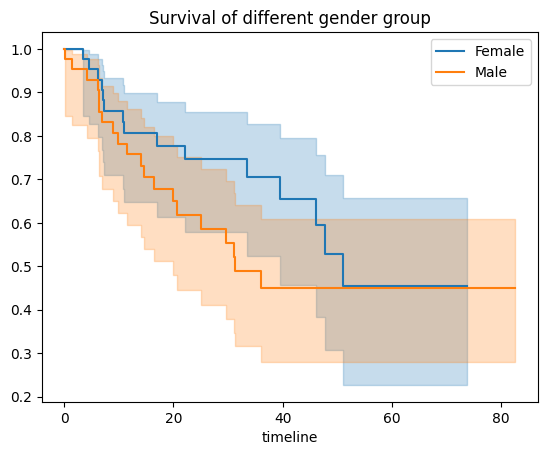

In [104]:
kmf = KaplanMeierFitter()
kmf.fit(durations = durations_A, event_observed = event_observed_A, label = "Female")
kmf.plot_survival_function()

kmf.fit(durations_B, event_observed = event_observed_B, label = "Male")
kmf.plot_survival_function()
plt.title("Survival of different gender group")

In [105]:

logrank_test_result = logrank_test(durations_A,durations_B,
    event_observed_A,event_observed_B )

logrank_test_result.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

p value 0.23>0.05 indicating there is no significant difference between both groups of gender

In [106]:
X2 = X1.dropna(axis=0)
X2

,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Infratentorial,90,6.11,SRS,0,57.64
1,Male,HG glioma,Supratentorial,90,19.35,SRT,1,8.98
2,Female,Meningioma,Infratentorial,70,7.95,SRS,0,26.46
3,Female,LG glioma,Supratentorial,80,7.61,SRT,1,47.80
4,Male,HG glioma,Supratentorial,90,5.06,SRT,1,6.30
...,...,...,...,...,...,...,...,...
83,Male,HG glioma,Supratentorial,80,0.16,SRT,1,20.69
84,Male,HG glioma,Supratentorial,80,19.81,SRT,1,6.39
85,Male,Meningioma,Supratentorial,90,2.50,SRT,0,32.82
86,Male,Meningioma,Supratentorial,90,2.02,SRS,0,42.07



   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.
[[<Axes: xlabel='rank-transformed time\n(p=0.3972)'>, <Axes: xlabel='km-transformed time\n(p=0.2643)'>], [<Axes: xlabel='rank-transformed time\n(p=0.5854)'>, <Axes: xlabel='km-transformed time\n(p=0.4248)'>], [<Axes: xlabel='rank-transformed time\n(p=0.8245)'>, <Axes: xlabel='km-transformed time\n(p=0.6881)'>], [<Axes: xlabel='rank-transformed time\n(p=0.3365)'>, <Axes: xlabel='km-transformed time\n(p=0.4695)'>], [<Axes: xlabel='rank-transformed time\n(p=0.6249)'>, <Axes: xlabel='km-transformed time\n(p=0.4549)'>], [<Ax

<lifelines.CoxPHFitter: fitted with 87 total observations, 52 right-censored observations>
             duration col = 'time'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 87
number of events observed = 35
   partial log-likelihood = -116.75
         time fit was run = 2023-10-20 17:14:35 UTC

---
                          coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                       
sex[T.Male]               0.18       1.20       0.36            -0.52             0.89                 0.59                 2.44
diagnosis[T.LG glioma]   -1.24       0.29       0.58            -2.38            -0.10                 0.09                 0.90
diagnosis[T.Meningioma]  -2.15       0.12       0.45            -3.04            -1.27                 0.05                 0.28
diagnosis[T.Other]       -1.27       0.28       0.62            -2.48            -0.06                 0.08                 0.94
loc[T.Supratentorial]     0.44       1.55       0.70            -0.94             1.82                 0.39                 6.17
ki                       -0.05       0.95       0.02            -0.09            -0.02                 0.91                 0.98
gtv                       0.03       1.03       0.02            -0.01             0.08                 0.99                 1.08
stereo[T.SRT]             0.18       1.19       0.60            -1.00             1.36                 0.37                 3.88

                          cmp to     z      p   -log2(p)
covariate                                               
sex[T.Male]                 0.00  0.51   0.61       0.71
diagnosis[T.LG glioma]      0.00 -2.14   0.03       4.95
diagnosis[T.Meningioma]     0.00 -4.78 <0.005      19.14
diagnosis[T.Other]          0.00 -2.05   0.04       4.65
loc[T.Supratentorial]       0.00  0.63   0.53       0.91
ki                          0.00 -3.00 <0.005       8.54
gtv                         0.00  1.54   0.12       3.00
stereo[T.SRT]               0.00  0.30   0.77       0.38
---
Concordance = 0.79
Partial AIC = 249.50
log-likelihood ratio test = 41.37 on 8 df
-log2(p) of ll-ratio test = 19.10

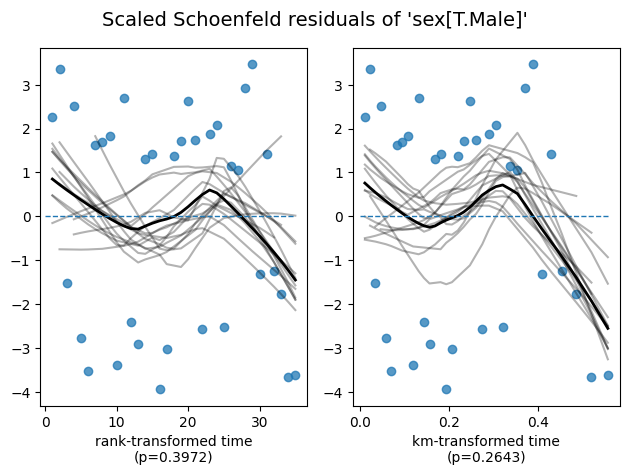

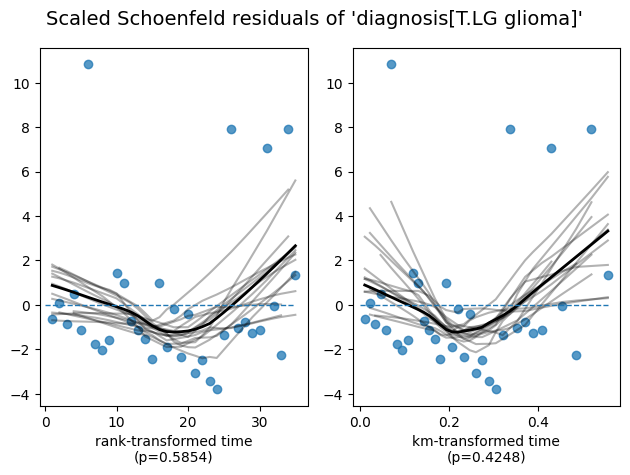

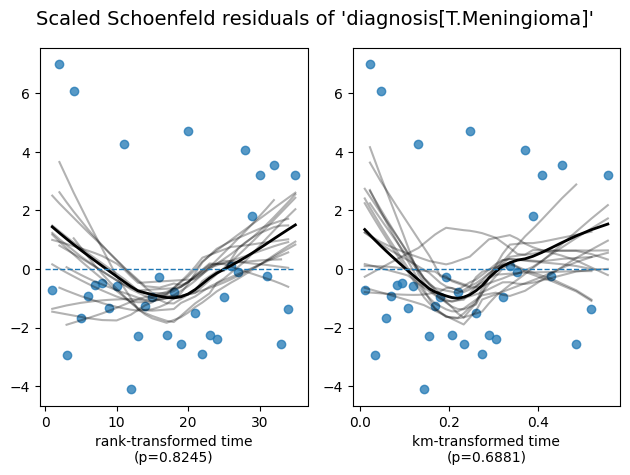

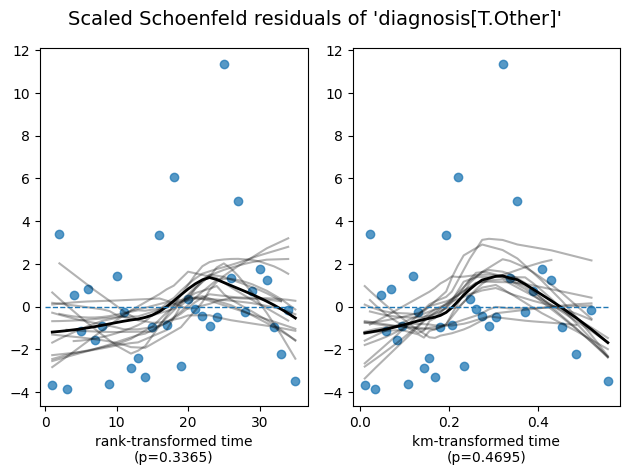

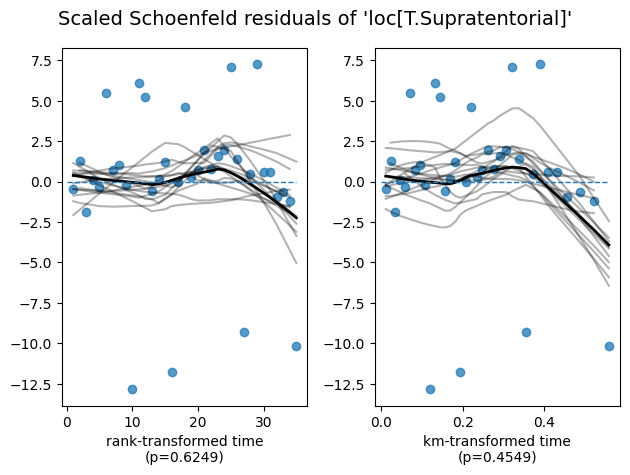

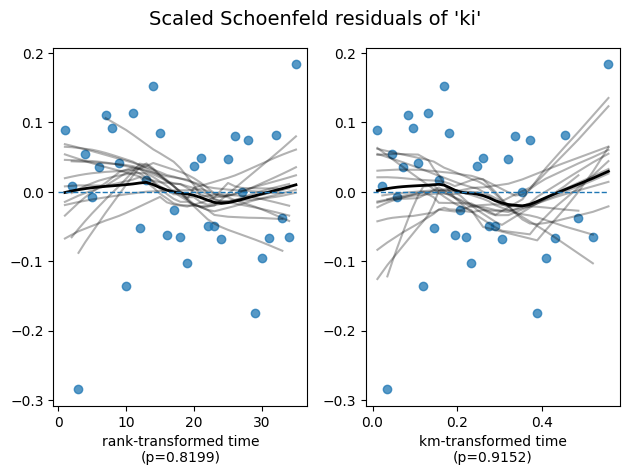

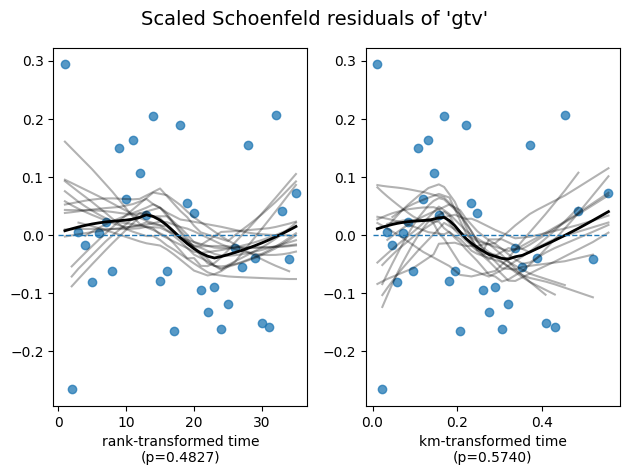

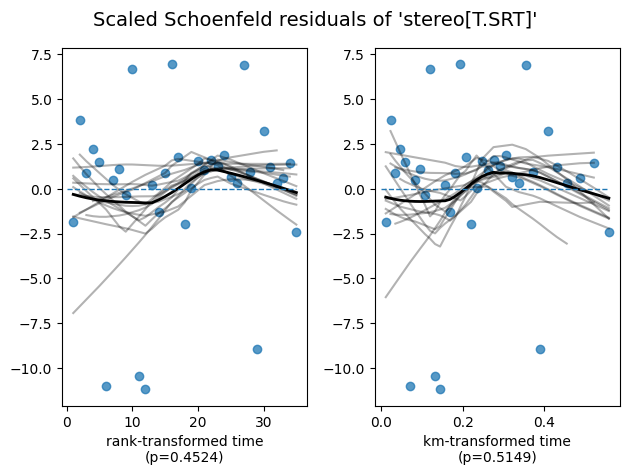

In [108]:
cph = CoxPHFitter()
cph.fit(X2, duration_col='time', event_col='status',formula='sex + diagnosis + loc + ki + gtv + stereo')
assumptions = cph.check_assumptions(X2, show_plots=True)
print(assumptions)
cph.print_summary()

a higher hazard means more at risk of the event occurring. Here, the value of exp(0.41) is called the hazard ratio.